C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\pyvista\jupyter\notebook.py:37: UserWarning: Failed to use notebook backend: 

cannot import name 'vtk' from 'trame.widgets' (C:\Users\Lenovo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\trame\widgets\__init__.py)

Falling back to a static output.
  warnings.warn(


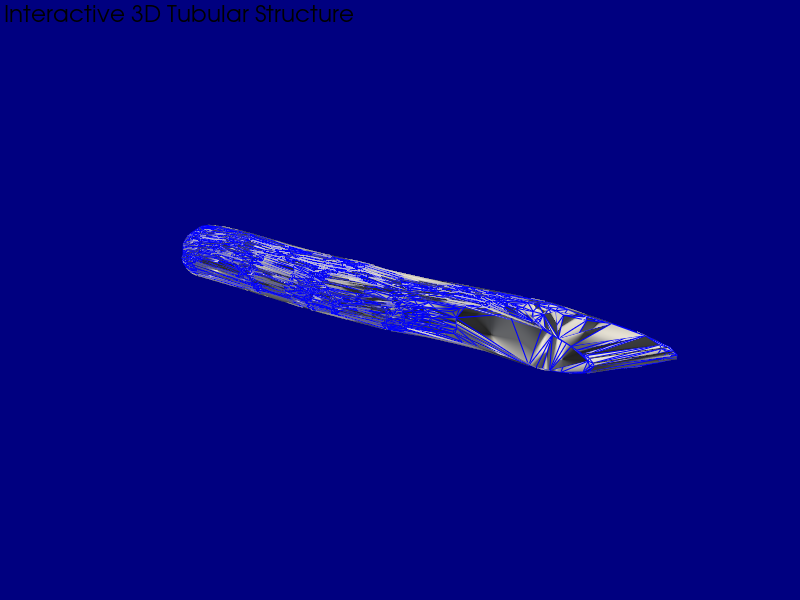

In [2]:
import numpy as np
import pyvista as pv
from vtkmodules.vtkFiltersCore import vtkDelaunay3D

# Load the .npy file
file_path = r"C:\Users\Lenovo\OneDrive - Syddansk Universitet\Dokumenter\GitHub\Broncho-Project\test\accumulated_point_cloud_frame_100.npy"
point_cloud = np.load(file_path)

# Convert the NumPy array to a PyVista PolyData object
mesh = pv.PolyData(point_cloud)

# Use VTK's Delaunay3D to create a 3D mesh
delaunay = vtkDelaunay3D()
delaunay.SetInputData(mesh)
delaunay.SetAlpha(0.1)  # Adjust alpha value as needed
delaunay.Update()

# Convert the result to PyVista and extract the surface
tubular_mesh = pv.wrap(delaunay.GetOutput()).extract_surface()

# Optional: Smooth the mesh for better visualization
smoothed_mesh = tubular_mesh.smooth(n_iter=20, relaxation_factor=0.1)

# Create a plotter for interactive 3D visualization
plotter = pv.Plotter(window_size=(800, 600))
plotter.add_mesh(smoothed_mesh, color="white", show_edges=True, edge_color="blue", smooth_shading=True)
plotter.set_background("navy")
plotter.add_text("Interactive 3D Tubular Structure", font_size=12)

# Show the interactive plot
plotter.show()